## Demo_Lips
This is a demo for visualizing the lipschitz constant of a Neuron Network

To run this demo from scratch, you need first generate a BadNet attack result by using the following cell

In [ ]:
! python ../../attack/badnet.py --save_folder_name badnet_demo

or run the following command in your terminal

```python attack/badnet.py --save_folder_name badnet_demo```

### Step 1: Import modules and set arguments

In [13]:
import sys, os
import yaml
import torch
import numpy as np
import torchvision.transforms as transforms
import matplotlib
from matplotlib.patches import Rectangle, Patch

sys.path.append("../")
sys.path.append("../../")
sys.path.append(os.getcwd())
from visual_utils import *
from utils.aggregate_block.dataset_and_transform_generate import (
    get_transform,
    get_dataset_denormalization,
)
from utils.aggregate_block.fix_random import fix_random
from utils.aggregate_block.model_trainer_generate import generate_cls_model
from utils.save_load_attack import load_attack_result
from utils.defense_utils.dbd.model.utils import (
    get_network_dbd,
    load_state,
    get_criterion,
    get_optimizer,
    get_scheduler,
)
from utils.defense_utils.dbd.model.model import SelfModel, LinearModel


In [7]:
### Basic setting: args
args = get_args(True)

########## For Demo Only ##########
args.yaml_path = "../../"+args.yaml_path
args.result_file_attack = "badnet_demo"
######## End For Demo Only ##########

with open(args.yaml_path, "r") as stream:
    config = yaml.safe_load(stream)
config.update({k: v for k, v in args.__dict__.items() if v is not None})
args.__dict__ = config
args = preprocess_args(args)
fix_random(int(args.random_seed))

save_path_attack = "../..//record/" + args.result_file_attack


### Step 2: Load model

In [8]:
# Load result
result_attack = load_attack_result(save_path_attack + "/attack_result.pt")

# Load model
model_visual = generate_cls_model(args.model, args.num_classes)
model_visual.load_state_dict(result_attack["model"])
model_visual.to(args.device)
# !!! Important to set eval mode !!!
model_visual.eval()
print(f"Load model {args.model} from {args.result_file_attack}")


Files already downloaded and verified
Files already downloaded and verified
loading...
Load model preactresnet18 from badnet_demo


### Step 3: Plot lipschitz constant

In [9]:
############## lipschitz constant ##################
print("Plotting lipschitz constant")

module_dict = dict(model_visual.named_modules())


module_names = module_dict.keys()

# Plot Conv2d or Linear
module_visual = [i for i in module_dict.keys() if isinstance(
    module_dict[i], torch.nn.Conv2d) or isinstance(module_dict[i], torch.nn.Linear) or isinstance(module_dict[i], torch.nn.BatchNorm2d)]


Plotting lipschitz constant


### Step 4: Collect Lips Constant

In [11]:
df = None

max_num_neuron = 0
for module_name in module_visual:
    target_layer = module_dict[module_name]
    
    print(f'Collecting Lips {target_layer}')
    if isinstance(target_layer, torch.nn.Linear):
        channel_lips = []
        for idx in range(target_layer.weight.shape[0]):
            w = target_layer.weight[idx].reshape(target_layer.weight.shape[1], -1)
            # Just norm of weight for linear layer
            channel_lips.append(torch.svd(w)[1].max())
        channel_lips = torch.Tensor(channel_lips)

    elif isinstance(target_layer, torch.nn.BatchNorm2d):
        std = target_layer.running_var.sqrt()
        weight = target_layer.weight

        channel_lips = []
        for idx in range(weight.shape[0]):
            w = conv.weight[idx].reshape(conv.weight.shape[1], -1) * (weight[idx]/std[idx]).abs()
            channel_lips.append(torch.svd(w)[1].max())
        channel_lips = torch.Tensor(channel_lips)

        
        # Convolutional layer should be followed by a BN layer by default
    elif isinstance(target_layer, torch.nn.Conv2d):
        conv = target_layer    
            
        channel_lips = []
        for idx in range(target_layer.weight.shape[0]):
            w = target_layer.weight[idx].reshape(target_layer.weight.shape[1], -1)
            channel_lips.append(torch.svd(w)[1].max())
        channel_lips = torch.Tensor(channel_lips)
    else:
        assert False, "Unknown layer type"

    for neuron_i in range(channel_lips.shape[0]):
        base_row = {}
        base_row['layer'] = module_name
        base_row['Neuron'] = neuron_i
        base_row['Lips'] = channel_lips[neuron_i].item()
        if df is None:
            df = pd.DataFrame.from_dict([base_row])
        else:
            df.loc[df.shape[0]] = base_row

### Step 5: Show the Lips

ploting conv1
ploting layer1.0.bn1
ploting layer1.0.conv1
ploting layer1.0.bn2
ploting layer1.0.conv2
ploting layer1.1.bn1
ploting layer1.1.conv1
ploting layer1.1.bn2
ploting layer1.1.conv2
ploting layer2.0.bn1
ploting layer2.0.conv1
ploting layer2.0.bn2
ploting layer2.0.conv2
ploting layer2.0.shortcut.0
ploting layer2.1.bn1
ploting layer2.1.conv1
ploting layer2.1.bn2
ploting layer2.1.conv2
ploting layer3.0.bn1
ploting layer3.0.conv1
ploting layer3.0.bn2
ploting layer3.0.conv2
ploting layer3.0.shortcut.0
ploting layer3.1.bn1
ploting layer3.1.conv1
ploting layer3.1.bn2
ploting layer3.1.conv2
ploting layer4.0.bn1
ploting layer4.0.conv1
ploting layer4.0.bn2
ploting layer4.0.conv2
ploting layer4.0.shortcut.0
ploting layer4.1.bn1
ploting layer4.1.conv1
ploting layer4.1.bn2
ploting layer4.1.conv2
ploting linear


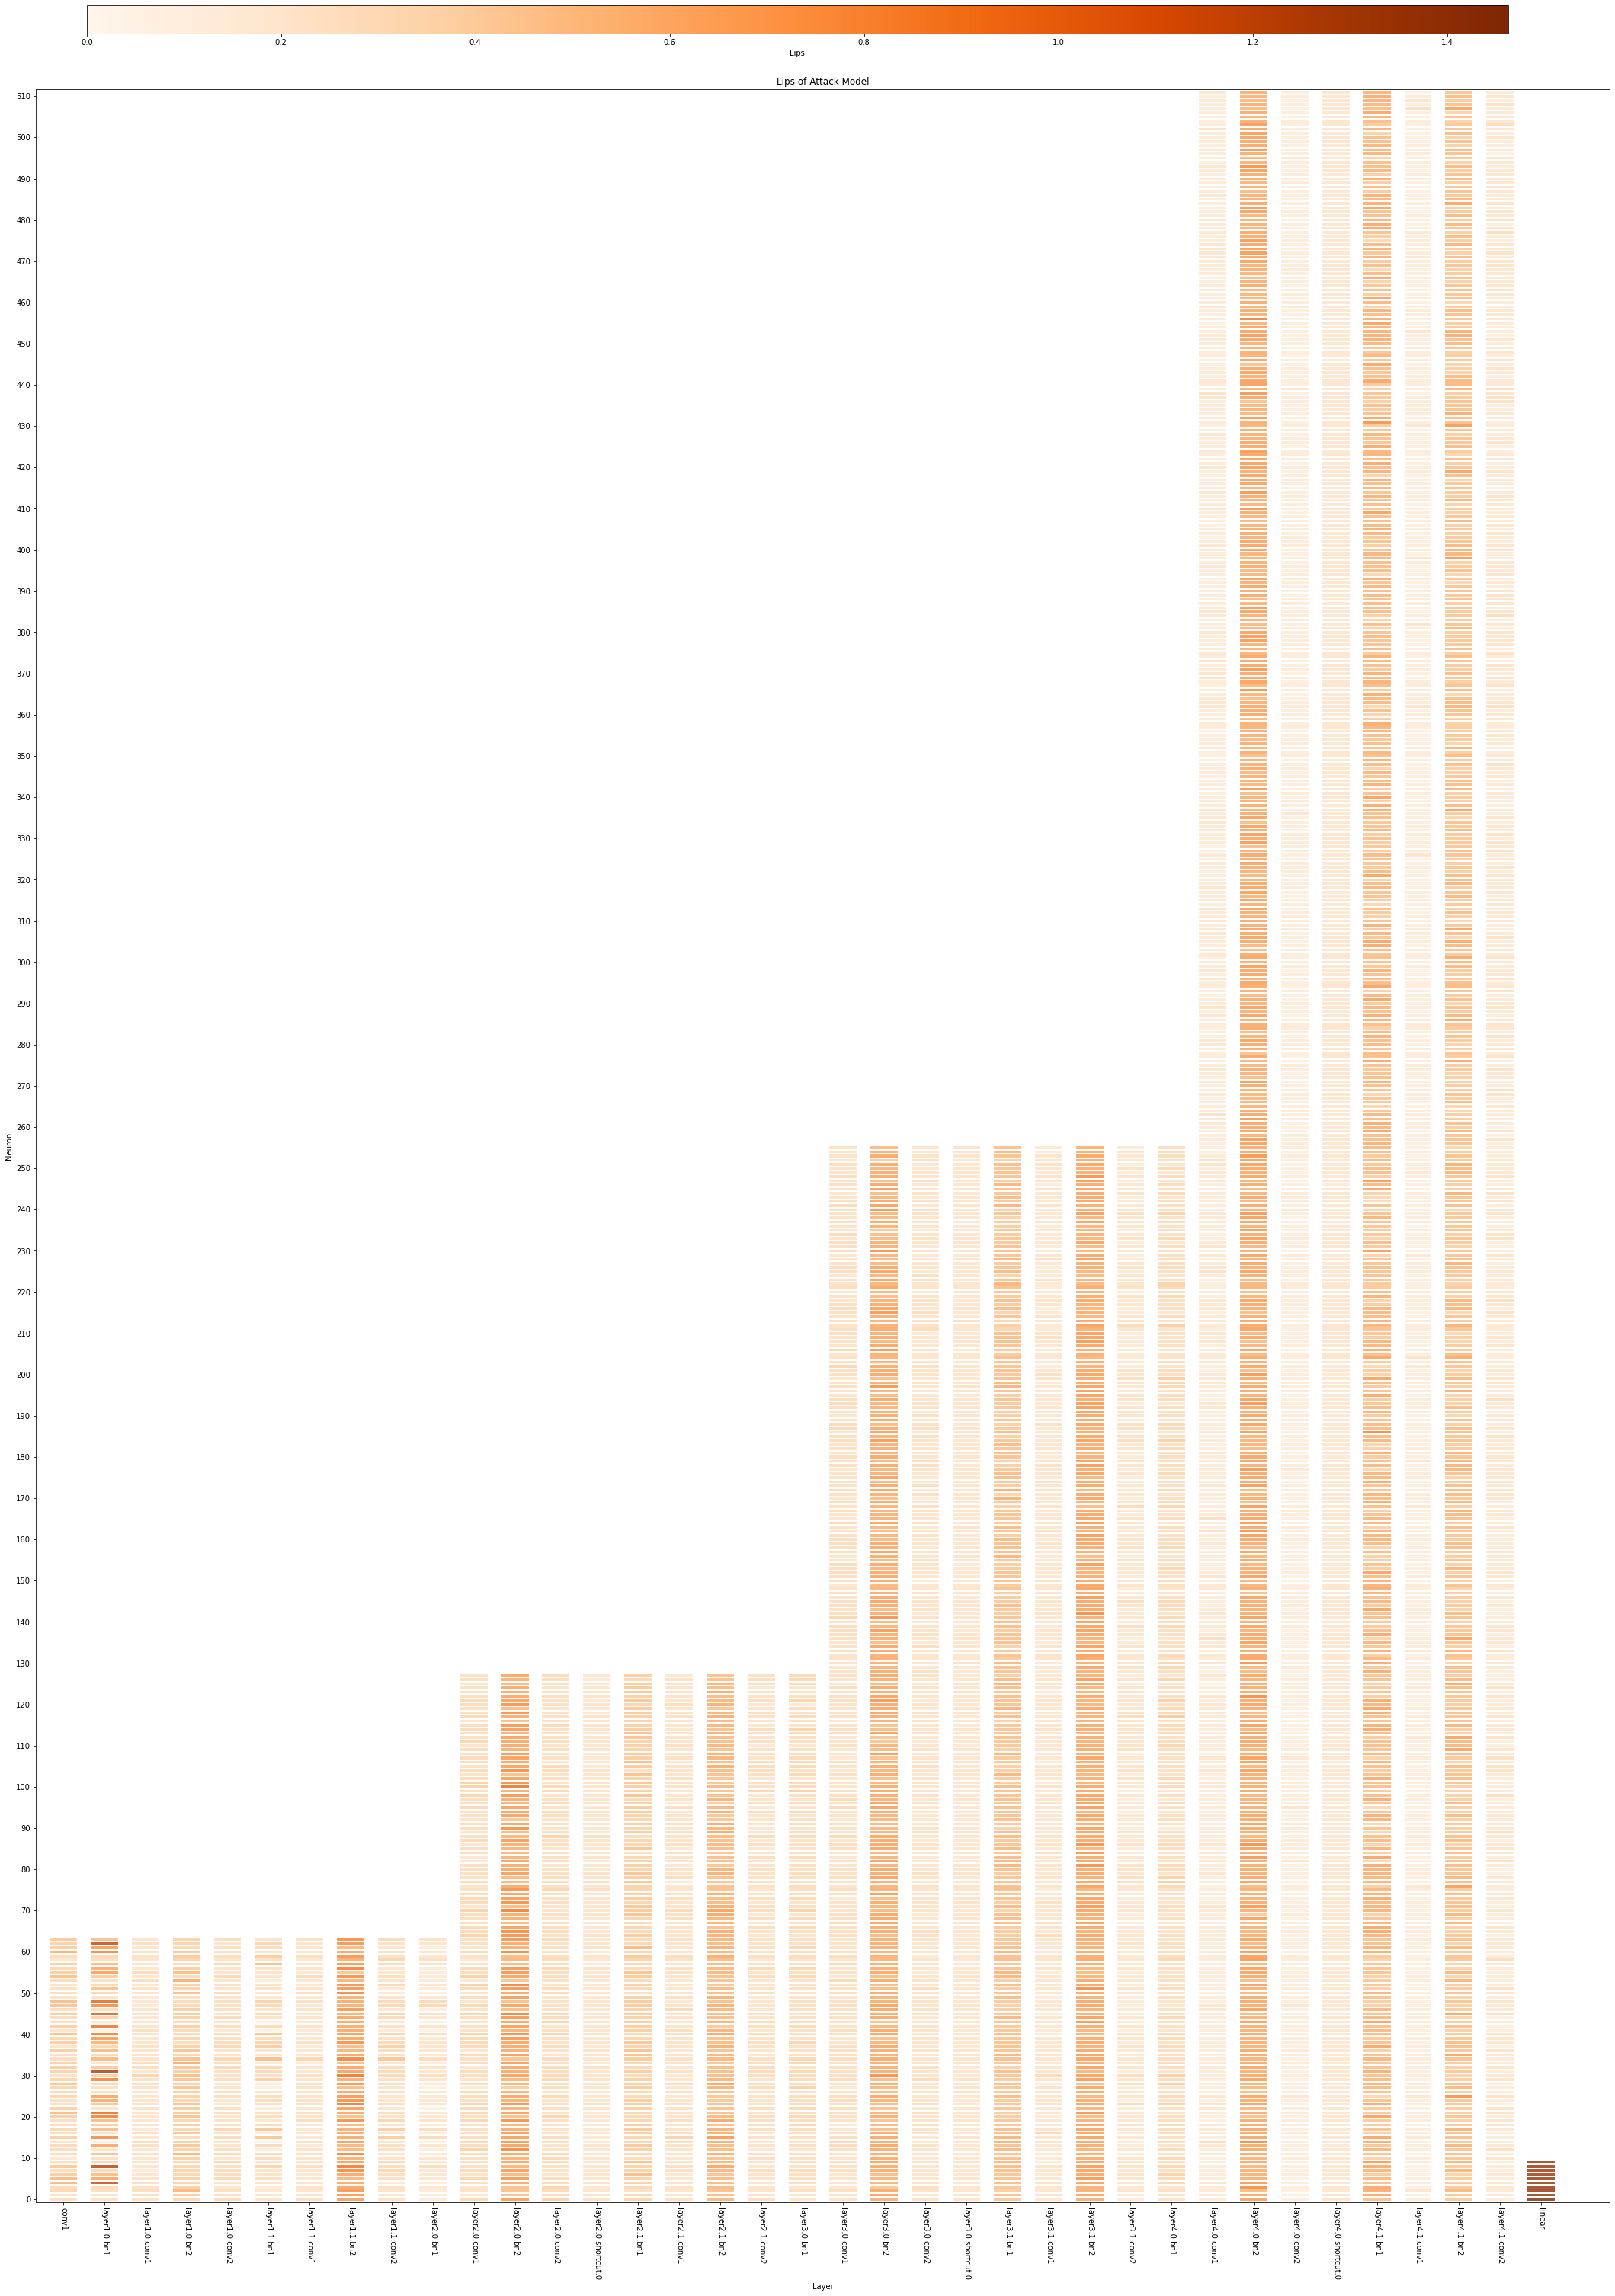

In [14]:
start_x0 = 0
height = 1
width = 1
vmin = 0
if args.normalize_by_layer:
    vmax = 1
else:
    vmax = df.Lips.max()
max_num_neuron = df.Neuron.max()


norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.Oranges)

fig, ax = plt.subplots(
    figsize=(int(len(module_visual)), int(max_num_neuron/10)))

ax.plot([0, 0], [0, 0])

for module_name in module_visual:
    print(f'ploting {module_name}')
    y_0 = 0
    layer_info = df[df.layer == module_name]
    layer_lips_max = layer_info['Lips'].max()
    total_neuron = layer_info.shape[0]
    for neuron_i in range(total_neuron):
        x_0 = start_x0
        base_row = layer_info.iloc[neuron_i]
        if args.normalize_by_layer:
            ax.add_patch(Rectangle((x_0, y_0), width, height,
                facecolor=mapper.to_rgba(base_row['Lips']/layer_lips_max),
                fill=True,
                lw=5,
                alpha=0.8))

        else:
            ax.add_patch(Rectangle((x_0, y_0), width, height,
                            facecolor=mapper.to_rgba(base_row['Lips']),
                            fill=True,
                            lw=5,
                            alpha=0.8))

        y_0 += 1.5*height
    start_x0 += 1.5*width
x_loc = [0.5*width+1.5*width*i for i in range(len(module_visual))]
y_loc = [0.5*height+1.5*height*i for i in range(max_num_neuron)]

ax.set_xlim(xmin=-0.5*width, xmax=1.5*width*(len(module_visual)+1))
ax.set_ylim(ymin=-0.5*height, ymax=1.5*height*(max_num_neuron+1))
ax.set_xticks(x_loc, module_visual, rotation=270)
ax.set_yticks(y_loc[::10], np.arange(max_num_neuron)[::10])
ax.set_title(f'Lips of Attack Model')
ax.set_ylabel('Neuron')
ax.set_xlabel('Layer')

cb_ax = fig.add_axes([0.15, 0.9, 0.7, 0.01])

fig.colorbar(mapper,
             cax=cb_ax, orientation="horizontal", label='Lips')

